# Imports

In [1]:
from pyspark.sql import DataFrame, functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, BooleanType, LongType, DoubleType, ArrayType, DateType, MapType
from pyspark.ml.feature import Bucketizer
from matplotlib import pyplot as plt
import seaborn as sns
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, MinHashLSH, MinHashLSHModel, CountVectorizer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.stat import Summarizer
from pyspark.ml.linalg import DenseVector
from pyspark.sql.functions import col
import pandas as pd
import numpy as np
from pyspark.sql import Window
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALSModel
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RankingMetrics


# Create Spark session

In [2]:
from dtu_ctfds_02807_proj.context_creation import create_context

local = True
sc, spark = create_context(local)

Cell has not been executed before, running...


24/12/03 15:53:12 WARN Utils: Your hostname, macbook.local resolves to a loopback address: 127.0.0.1; using 192.168.86.58 instead (on interface en0)
24/12/03 15:53:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/03 15:53:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load data

In [3]:
if local:
    # Use sample with users that have left many reviews
    game_reviews = spark.read.parquet('data/many_reviews_users_parquet')
    games = spark.read.parquet('data/steam_games_parquet')
else:
    game_reviews = spark.read.parquet("file:////work/ds/steam_reviews_parquet")
    games = spark.read.parquet('file:////work/ds/steam_games_parquet')
    

# game_reviews: DataFrame = game_reviews.persist()
# games: DataFrame = games.persist()

# ALS Model

## Leave one out split

In [28]:
game_ratings = game_reviews\
    .filter(F.col("author_steamid").isNotNull())\
    .withColumn(
        'rating',
        F.when(game_reviews.recommended == True, 1).otherwise(0)
    )

user_indexer = StringIndexer(inputCol="author_steamid", outputCol="user_index")

game_ratings = user_indexer.fit(game_ratings).transform(game_ratings)

window_spec = Window\
    .partitionBy("author_steamid")\
    .orderBy(F.desc("rating"))

df_with_row_number = game_ratings\
    .withColumn('row_number', F.row_number().over(window_spec))

reviews_test = df_with_row_number\
    .filter(F.col('row_number') == 1)\
    .filter(F.col('rating') == 1)\
    .drop('row_number')\
    .cache()

reviews_train = df_with_row_number\
    .filter(F.col('row_number') > 1)\
    .drop('row_number')


reviews_train_positive = reviews_train.filter(F.col('rating') == 1)
reviews_train_negative = reviews_train.filter(F.col('rating') == 0)

negative_count = reviews_train_negative.count()
positive_count = reviews_train_positive.count()

oversample_factor = positive_count / negative_count

# Determine the number of full copies and the fractional part
full_copies = int(oversample_factor)  # Integer part of the oversample factor
fractional_part = oversample_factor - full_copies  # Fractional part for additional sampling

# Create multiple full copies of the minority data
oversampled_minority_data = reviews_train_negative
for _ in range(full_copies - 1):  # Full copies
    oversampled_minority_data = oversampled_minority_data.union(reviews_train_negative)

# Add the fractional part if it's greater than 0
if fractional_part > 0:
    fractional_sample = reviews_train_negative.sample(withReplacement=True, fraction=fractional_part, seed=42)
    oversampled_minority_data = oversampled_minority_data.union(fractional_sample)

# Combine oversampled minority class with majority
reviews_train = oversampled_minority_data.union(reviews_train_negative)

## Train explicit ALS model using cross validation

In [31]:
reviews_train = reviews_train.na.drop(subset=["user_index", "app_id", "rating"])

# Simple model for debugging
explicit_als = ALS(
    userCol="user_index",
    itemCol="app_id",
    ratingCol="rating",
    coldStartStrategy="drop"
)

# Simple example for debugging
param_grid = ParamGridBuilder() \
    .addGrid(explicit_als.maxIter, [10]) \
    .addGrid(explicit_als.rank, [20]) \
    .addGrid(explicit_als.regParam, [0.1]) \
    .build()

rmse_evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

# Define CrossValidator
cv = CrossValidator(
    estimator=explicit_als,
    estimatorParamMaps=param_grid,
    evaluator=rmse_evaluator,
    numFolds=3,
)

# Fit the model
model = cv.fit(reviews_train)

In [18]:

implicit_als = ALS(
    maxIter=50,
    rank=20,
    regParam=0.01,
    userCol="user_index",
    itemCol="app_id",
    ratingCol="author_playtime_forever",
    coldStartStrategy="drop",
    implicitPrefs=True
)

In [32]:
# Extract the best model
explicit_model: ALSModel = model.bestModel

# Print parameters of the best model
print('Rank:', explicit_model.rank)
print('MaxIter:', explicit_model._java_obj.parent().getMaxIter())
print('RegParam:', explicit_model._java_obj.parent().getRegParam())

Rank: 20
MaxIter: 10
RegParam: 0.1


In [43]:
explicit_predictions = explicit_model.transform(reviews_test).cache()

In [21]:
implicit_model = implicit_als.fit(reviews_train)

implicit_predictions = implicit_model.transform(reviews_test).cache()

# implicit_predictions\
#     .show(5)

## Performing validation on explicit model as if it was a classification problem

In [44]:
# Round predictions to 0 or 1
rounded_explicit_predictions = explicit_predictions\
    .withColumn(
        'prediction',
        F.when(F.col('prediction') > 0.5, 1.).otherwise(0)
    )

In [ ]:
confusion_matrix_df = (
    rounded_explicit_predictions.groupBy("rating", "prediction")
    .agg(F.count("*").alias("count"))
    .toPandas()  # This will now be a small dataframe suitable for pandas
)


# Pivot the table to create a confusion matrix
confusion_matrix_pivot = confusion_matrix_df.pivot(
    index="rating", columns="prediction", values="count"
).fillna(0)

# Convert to a numeric matrix (Seaborn requires it)
confusion_matrix = confusion_matrix_pivot.to_numpy()

# Safely access matrix elements with a fallback to zero
def safe_get(matrix, row, col, default=0):
    try:
        return matrix[row, col]
    except IndexError:
        return default

# Access confusion matrix elements with a fallback to zero
tn = safe_get(confusion_matrix, 0, 0)
fp = safe_get(confusion_matrix, 0, 1)
fn = safe_get(confusion_matrix, 1, 0)
tp = safe_get(confusion_matrix, 1, 1)

precision = tp / (tp + fp) if tp + fp > 0 else 0
recall = tp / (tp + fn) if tp + fn > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=confusion_matrix_pivot.columns,
            yticklabels=confusion_matrix_pivot.index)

# Add labels, title, and formatting
plt.xlabel("Predicted Ratings")
plt.ylabel("True Ratings")
plt.title("Confusion Matrix")
plt.show()

ZeroDivisionError: division by zero

In [37]:
reviews_by_user = reviews_train\
    .groupBy("author_steamid")\
    .agg(
        F.count('review_id').alias('review_count'),
    )

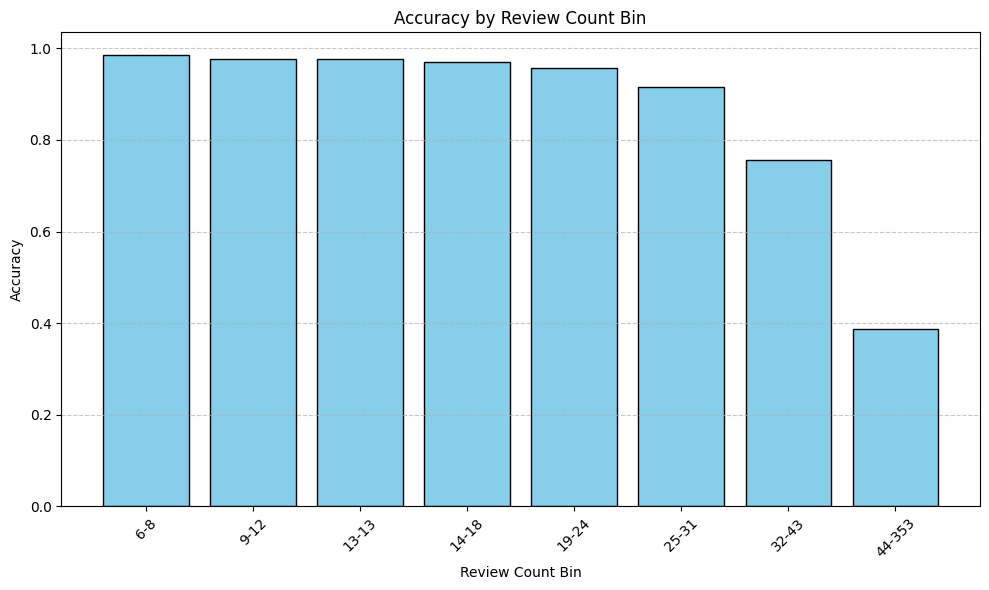

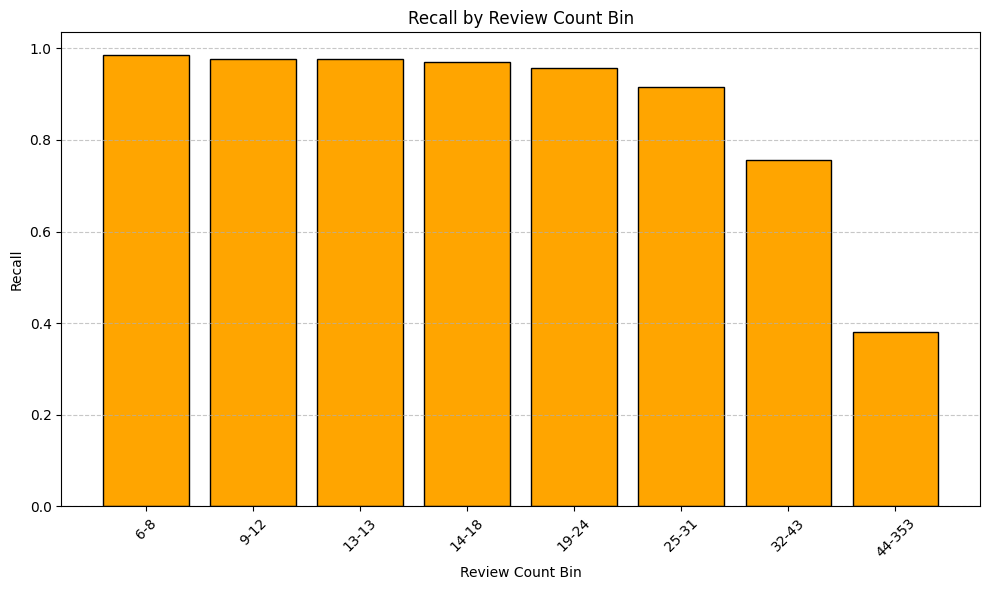

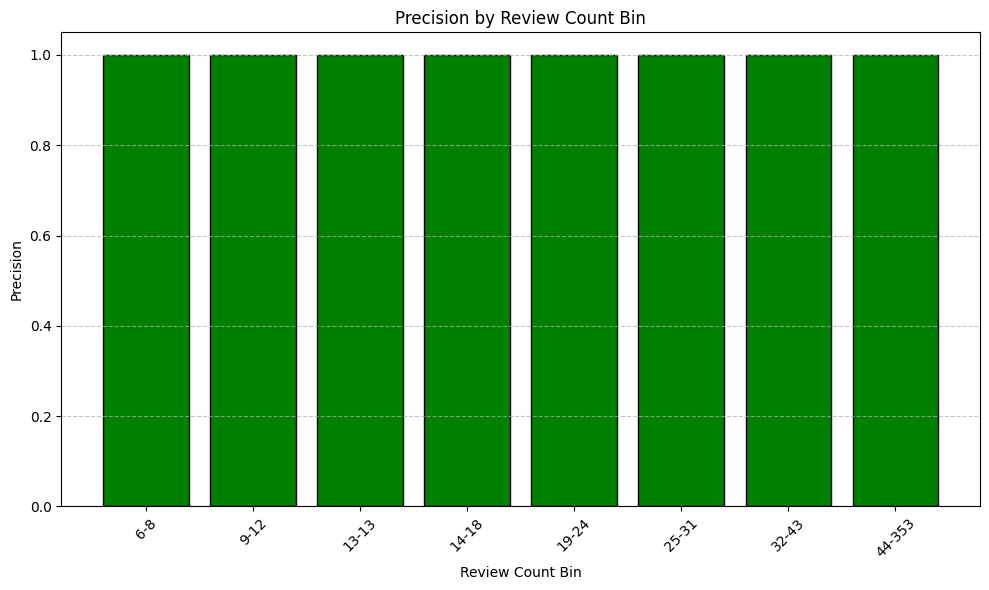

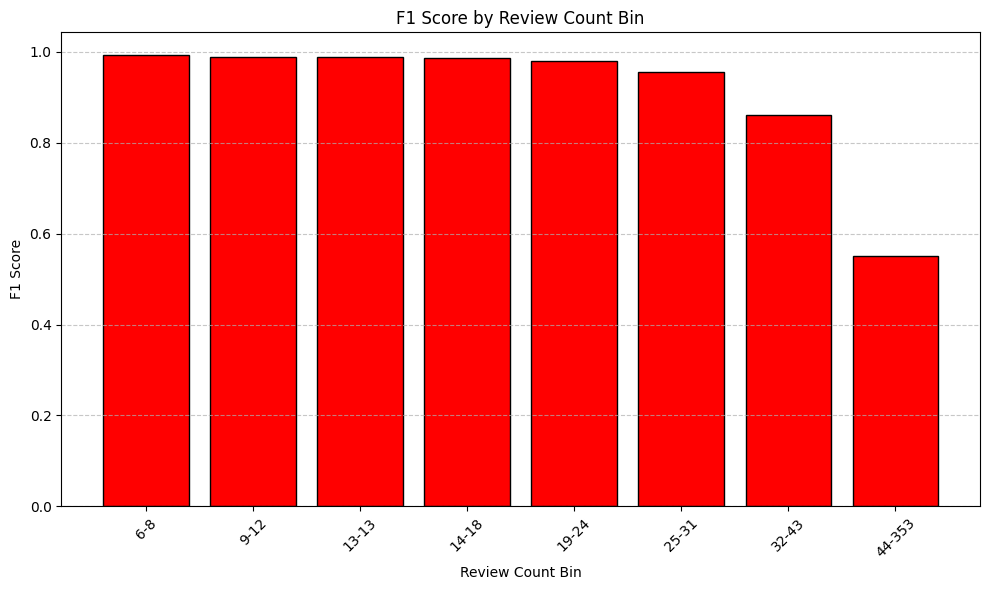

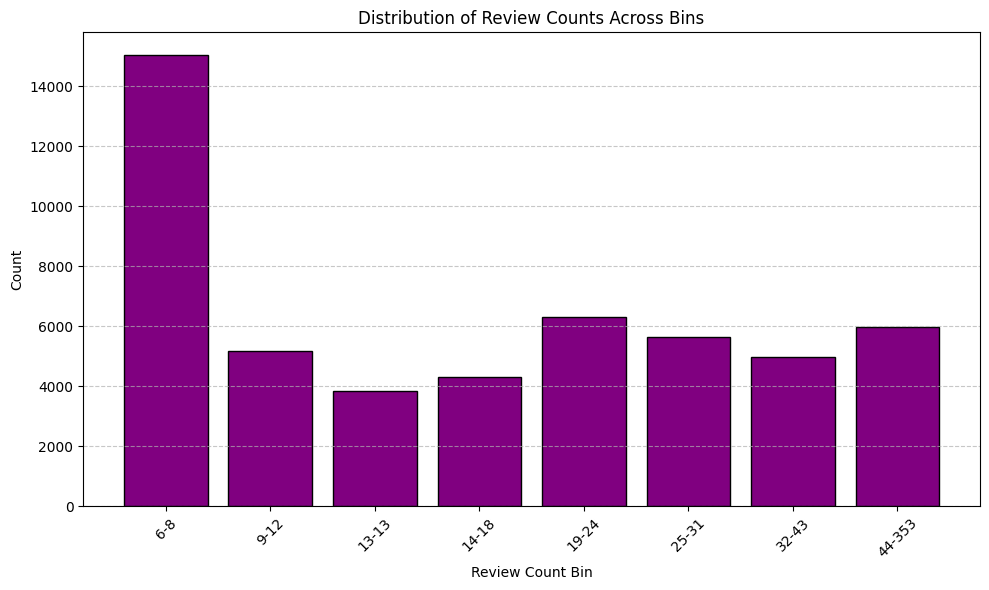

In [38]:
rounded_pred_review_count = rounded_explicit_predictions.drop("review_count")\
    .join(reviews_by_user, on="author_steamid", how="inner").cache()

# Generate n same-sized buckets for review counts
n_buckets = 10
splits = rounded_pred_review_count\
    .select("review_count")\
    .approxQuantile("review_count", [i / n_buckets for i in range(n_buckets + 1)], 0.01)

splits = np.unique(splits)

# Step 2: Generate dynamic bin labels
bin_labels = [
    f"{int(splits[i])}-{int(splits[i+1]) - 1}" if splits[i+1] != float('inf') else f"{int(splits[i])}+"
    for i in range(len(splits) - 1)
]

# Step 3: Apply Bucketizer
bucketizer = Bucketizer(
    splits=splits,
    inputCol="review_count",
    outputCol="review_count_bin"
)

binned_df = bucketizer.transform(rounded_pred_review_count)

# Map bin indices to dynamic labels
def map_bins(bin_index):
    return bin_labels[int(bin_index)] if int(bin_index) < len(bin_labels) else "Unknown"

map_bins_udf = F.udf(map_bins, StringType())

binned_df = binned_df.withColumn(
    "review_count_bin_label",
    map_bins_udf(F.col("review_count_bin"))
)

# Step 4: Aggregate metrics by bin
metrics_df = binned_df.groupBy("review_count_bin", "review_count_bin_label").agg(
    F.count(F.when((F.col("prediction") == 1) & (F.col("rating") == 1), 1)).alias("TP"),
    F.count(F.when((F.col("prediction") == 1) & (F.col("rating") == 0), 1)).alias("FP"),
    F.count(F.when((F.col("prediction") == 0) & (F.col("rating") == 1), 1)).alias("FN"),
    F.count(F.when((F.col("prediction") == 0) & (F.col("rating") == 0), 1)).alias("TN")
)

# Sort the aggregated DataFrame by the numeric bin index (review_count_bin)
sorted_metrics_df = metrics_df.orderBy("review_count_bin")

# Collect metrics and calculate performance measures
metrics_collected = sorted_metrics_df.collect()

metrics_results = []
for row in metrics_collected:
    bin_label = row["review_count_bin_label"]
    TP = row["TP"]
    FP = row["FP"]
    FN = row["FN"]
    TN = row["TN"]

    accuracy = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    metrics_results.append((bin_label, accuracy, precision, recall, f1_score))

# Step 5: Convert to Pandas
metrics_results_df = pd.DataFrame(
    metrics_results, 
    columns=["Review Count Bin", "Accuracy", "Precision", "Recall", "F1"]
)

# Step 6: Plot metric results
plt.figure(figsize=(10, 6))
plt.bar(metrics_results_df["Review Count Bin"], metrics_results_df["Accuracy"], color="skyblue", edgecolor="black")
plt.title("Accuracy by Review Count Bin")
plt.xlabel("Review Count Bin")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(metrics_results_df["Review Count Bin"], metrics_results_df["Recall"], color="orange", edgecolor="black")
plt.title("Recall by Review Count Bin")
plt.xlabel("Review Count Bin")
plt.ylabel("Recall")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(metrics_results_df["Review Count Bin"], metrics_results_df["Precision"], color="green", edgecolor="black")
plt.title("Precision by Review Count Bin")
plt.xlabel("Review Count Bin")
plt.ylabel("Precision")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(metrics_results_df["Review Count Bin"], metrics_results_df["F1"], color="red", edgecolor="black")
plt.title("F1 Score by Review Count Bin")
plt.xlabel("Review Count Bin")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Step 7: Plot the bin distribution
bins_data = binned_df.groupBy("review_count_bin", "review_count_bin_label").count()
sorted_bins_data = bins_data.orderBy("review_count_bin").toPandas()

plt.figure(figsize=(10, 6))
plt.bar(sorted_bins_data["review_count_bin_label"], sorted_bins_data["count"], color="purple", edgecolor="black")
plt.title("Distribution of Review Counts Across Bins")
plt.xlabel("Review Count Bin")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [39]:
# Step 2: Generate predictions for all user-item pairs (for recommendation)
user_item_pairs = reviews_test.select("user_index").distinct().crossJoin(
    reviews_test.select("app_id").distinct()
)
predictions = implicit_model.transform(user_item_pairs)

# Step 3: Collect top N recommendations for each user
N = 20  # Define N
user_recommendations = (
    predictions
    .orderBy("user_index", F.desc("prediction"))
    .groupBy("user_index")
    .agg(F.collect_list("app_id").alias("recommendations"))
)

# Get top N items
user_recommendations = user_recommendations.withColumn(
    "recommendations", F.slice("recommendations", 1, N)
)

# Step 4: Prepare ground truth data
ground_truth = (
    reviews_test.groupBy("user_index")
    .agg(F.collect_list("app_id").alias("groundTruth"))
)

# Step 5: Join recommendations with ground truth
recommendation_and_truth = user_recommendations.join(
    ground_truth, on="user_index"
).select("recommendations", "groundTruth")

# Step 6: Convert data into an RDD of (predicted, actual) for RankingMetrics
rdd_recommendation_truth = recommendation_and_truth.rdd.map(
    lambda row: (row["recommendations"], row["groundTruth"])
)

# Step 7: Evaluate Precision@N using RankingMetrics
metrics = RankingMetrics(rdd_recommendation_truth)

recall_at_n = metrics.recallAt(N)
precision_at_n = metrics.precisionAt(N)

f1_at_n = 2 * (precision_at_n * recall_at_n) / (precision_at_n + recall_at_n) if (precision_at_n + recall_at_n) > 0 else 0

print(f"Precision@{N}: {precision_at_n}")
print(f"Recall@{N}: {recall_at_n}")
print(f"F1@{N}: {f1_at_n}")


/Users/esben/dev/dtu/03semester/CTFDS/DTU-CTFDS-02807-PROJ/.venv/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision@20: 0.009695281236104943
Recall@20: 0.19390562472209874
F1@20: 0.018467202354485606


# The random case

In [27]:
# Calculate N (Total games) and R (Average relevant games per user)
# N = games.select("app_id").distinct().count()
N = reviews_train.select("app_id").distinct().count()
R = reviews_test.filter(
        F.col("recommended") == True
    )\
    .groupBy("author_steamid")\
    .count()\
    .agg(F.avg("count"))\
    .first()[0]

# Parameters
k = 20  # Number of random recommendations

# Calculate Precision, Recall, and F1
precision = R / N
recall = k / N
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Precision (Random): {precision}")
print(f"Recall (Random): {recall}")
print(f"F1 Score (Random): {f1}")


Precision (Random): 0.0031746031746031746
Recall (Random): 0.06349206349206349
F1 Score (Random): 0.006046863189720333
